<a href="https://colab.research.google.com/github/YoungnohLee/fin/blob/main/%5Bfin%5D_DRL_baseline_YN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package Install

In [333]:
pip install -U ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [334]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-m0ut58xm
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-m0ut58xm
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d9f0af8021e0995dec71043ed517af954e3f1a4d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-tamd7z4v/elegantrl_7

In [335]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

## Create Folder


In [336]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

## Download data

In [337]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [338]:
# instantiated train/test date
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-28'

In [339]:
import yfinance as yf

ticker = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']
stocks = yf.download(ticker, start = TRAIN_START_DATE, end = TRADE_END_DATE )

[*********************100%***********************]  9 of 9 completed


## Preprocessing

In [340]:
df =  YahooDownloader(start_date = TRAIN_START_DATE,
                      end_date = TRADE_END_DATE,
                      ticker_list = ticker).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30357, 8)


In [341]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.488926,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,38.080173,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.385942,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.880188,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.150223,8449400,XLK,0


In [342]:
INDICATORS

# instantiated rolling period

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [343]:
fe = FeatureEngineer(
    use_technical_indicator = True,
    tech_indicator_list = INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False
)
preprocessed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3372, 8)
Successfully added vix
Successfully added turbulence index


In [344]:
preprocessed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.488926,7567500,XLB,0,0.0,25.646678,25.413585,100.0,66.666667,100.0,25.488926,25.488926,20.040001,0.0
1,2010-01-04,57.919998,58.810001,57.790001,38.080173,16928400,XLE,0,0.0,25.646678,25.413585,100.0,66.666667,100.0,38.080173,38.080173,20.040001,0.0
2,2010-01-04,11.795288,11.965881,11.770918,9.385942,92942347,XLF,0,0.0,25.646678,25.413585,100.0,66.666667,100.0,9.385942,9.385942,20.040001,0.0
3,2010-01-04,28.090000,28.320000,27.959999,21.880188,7471500,XLI,0,0.0,25.646678,25.413585,100.0,66.666667,100.0,21.880188,21.880188,20.040001,0.0
4,2010-01-04,23.139999,23.290001,23.100000,19.150223,8449400,XLK,0,0.0,25.646678,25.413585,100.0,66.666667,100.0,19.150223,19.150223,20.040001,0.0


In [345]:
list_ticker = preprocessed["tic"].unique().tolist() # ticker list
list_date = list(pd.date_range(preprocessed['date'].min(), preprocessed['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

preprocess_full = pd.DataFrame(combination, columns=['date','tic']).merge(preprocessed, on=['date','tic'],how='left')
preprocess_full = preprocess_full[preprocess_full['date'].isin(preprocessed['date'])]
preprocess_full = preprocess_full.sort_values(['date','tic'])

preprocess_full = preprocess_full.fillna(0)

In [346]:
mvo_df = preprocess_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
mvo_df.head(10) # 종가만

,date,tic,close
0,2010-01-04,XLB,25.488926
1,2010-01-04,XLE,38.080173
2,2010-01-04,XLF,9.385942
3,2010-01-04,XLI,21.880188
4,2010-01-04,XLK,19.150223
5,2010-01-04,XLP,18.718464
6,2010-01-04,XLU,19.481916
7,2010-01-04,XLV,25.213634
8,2010-01-04,XLY,25.227167
9,2010-01-05,XLB,25.571337


## Data Split

In [347]:
train = data_split(preprocess_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(preprocess_full, TRADE_START_DATE, TRADE_END_DATE)
print(len(train))
print(len(trade))

26613
3735


In [348]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,XLK,151.279999,151.929993,149.240005,147.263290,16707800.0,3.0,-1.092961,159.319729,147.459950,44.208299,-191.070247,44.293885,153.921232,152.236039,23.139999,11.930186
2956,2021-09-30,XLP,70.269997,70.330002,68.809998,66.321983,16259900.0,3.0,-0.469129,70.213495,66.494781,41.476678,-183.995203,49.963878,68.614721,68.400089,23.139999,11.930186
2956,2021-09-30,XLU,64.629997,64.669998,63.790001,61.087296,13571300.0,3.0,-0.913167,67.296321,60.071165,40.931731,-144.183581,48.685758,64.252754,63.676682,23.139999,11.930186
2956,2021-09-30,XLV,129.309998,130.119995,127.190002,124.387512,21653100.0,3.0,-1.200210,134.120940,124.282054,41.880765,-174.877983,47.485272,130.075670,129.017882,23.139999,11.930186
2956,2021-09-30,XLY,182.520004,182.660004,179.449997,177.093872,8244800.0,3.0,0.207884,183.899811,177.238529,48.094968,-67.028656,26.714739,179.800808,179.116695,23.139999,11.930186


In [349]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,XLB,79.489998,80.800003,78.889999,77.827316,9250000.0,4.0,-0.978684,82.849752,75.685200,44.479118,-107.583774,37.463188,80.236746,80.251991,21.1,5.312999
0,2021-10-01,XLE,52.470001,53.889999,52.470001,50.451195,41656000.0,4.0,1.182468,50.653989,42.164670,59.586533,191.736041,29.265956,45.805905,45.741456,21.1,5.312999
0,2021-10-01,XLF,37.630001,38.410000,37.490002,37.005867,70444000.0,4.0,0.098726,37.574481,35.488707,53.517090,13.822209,5.497651,36.698644,36.249978,21.1,5.312999
0,2021-10-01,XLI,98.459999,99.709999,97.480003,96.721664,17051800.0,4.0,-0.976384,101.326245,95.073020,44.433466,-120.623520,39.320859,99.246638,99.847297,21.1,5.312999
0,2021-10-01,XLK,149.860001,151.899994,148.339996,149.482269,22741900.0,4.0,-1.163567,159.062869,147.038158,47.870371,-166.873863,47.408754,153.858113,152.269128,21.1,5.312999


# Env

In [350]:
print(gym.__version__)

0.28.1


In [351]:
import inspect
source_code = inspect.getsource(StockTradingEnv)
# paste class `StockTradingEnv` from source code above
print(source_code)

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.bu

✅ Check class `StockTradingEnv(gym.Env)` to customize/debug errors

In [352]:
from __future__ import annotations

from typing import List

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
matplotlib.use("Agg")

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        # action space
        # normalize action space with action space dimension 
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        # state space
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(self,seed=None):
        # 이 부분이 원래는 seed 가 arg로 없었는데, DummyVecEnv와 compatible 해야하기 때문에 seed=None 을 arg로 넣었음.
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda:self])
        obs = e.reset()
        return e, obs


In [353]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension # 1 + 2*주식 개수 + 보조지표*주식개수
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 91


In [354]:
# instantiated arguments 

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100, # max number of stocks agent can buy at a time
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

### Q.

Environment구축을 class `StockTradingEnv` 으로 구현함.

따라서 StockTradingEnv 를 자세하게 들여다 볼 필요가 있음.

또한 State Spaces 가 위와같이 상정되어 있는 이유를 뜯어볼 이유가 있음. `1 + 2*stock_dimension`인 이유가 뭘까?

Action Spaces는 어떻게 구현되어 있는 것인가? (Action Space없이도 RL이 가능한가?)


### A.

`state_space = 1 + 2*stock_dimension`에서 1은 remaining balance에 해당, 2는 각각 stock의 stock price, stock shares에 해당한다. class `StockTradingEnv`내 `def _initiate_state(self):`를 보면 알 수 있다. 

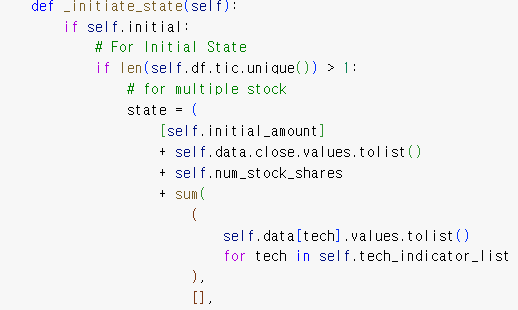

### Q.

그렇다면 해당 Env 에서 Reward Setting이 어떻게 되었을까?



### A. 

해당 Env 내부 `tot_reward`를 보면 알 수 있다.

**Reward Setting은 단순하게도, Maximize total balance at time T 이다.**

## Env for Training

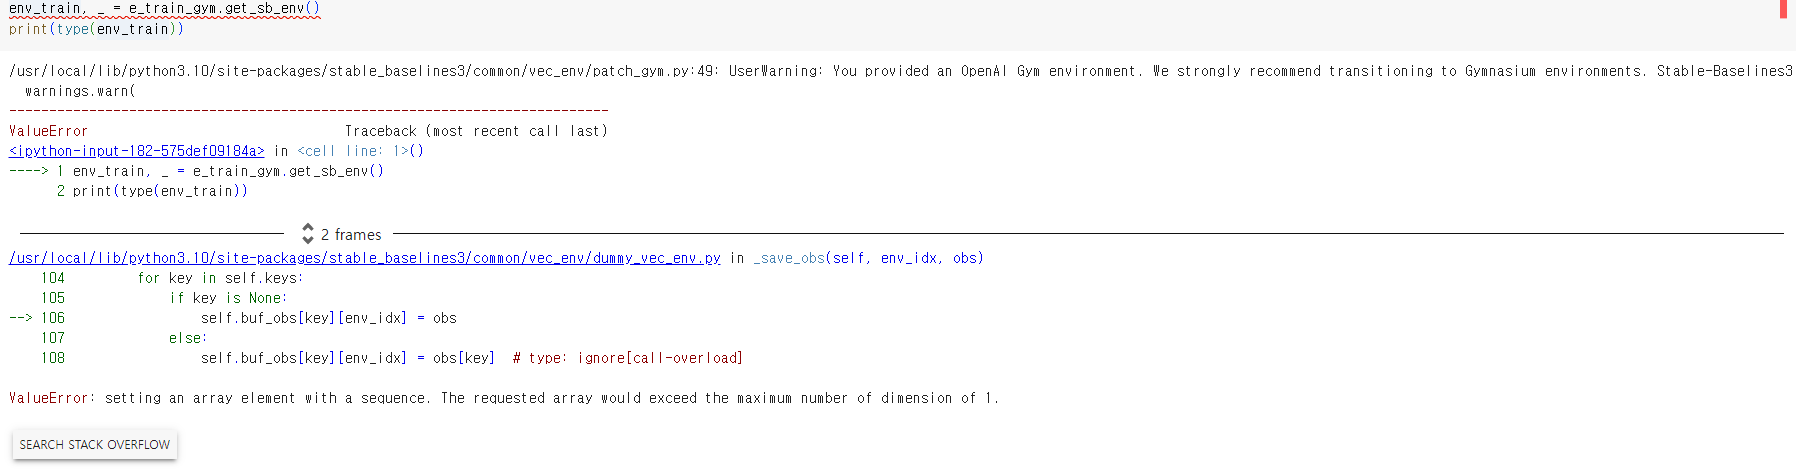

다음과 같은 에러가 뜸. 

Open AI gym environment가 아닌 gymnasium으로 바꾸라고 권고함

Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues. 라는 에러가 뜸

따라서 해당 py를 import 해줌.

또한 DummyVecEnv 에러를 보면 길이 1짜리 element가 와야 할 자리에 sequence가 와있어서 에러가 뜬다고 함. 생성된 인스턴스 환경 `e_train_gym`이 어떤 형식으로 오는지는 더 살펴봐야 겠지만 일단은 잘 모르겠어서 위에 조치를 하고 넘어감.

In [355]:
DummyVecEnv([lambda:e_train_gym])

In [356]:
# from collections import OrderedDict
# from typing import Sequence
# from copy import deepcopy

# import numpy as np

# from stable_baselines3.common.vec_env.base_vec_env import VecEnv
# from stable_baselines3.common.vec_env.util import copy_obs_dict, dict_to_obs, obs_space_info


# class DummyVecEnv(VecEnv):
#     """
#     Creates a simple vectorized wrapper for multiple environments, calling each environment in sequence on the current
#     Python process. This is useful for computationally simple environment such as ``cartpole-v1``, as the overhead of
#     multiprocess or multithread outweighs the environment computation time. This can also be used for RL methods that
#     require a vectorized environment, but that you want a single environments to train with.

#     :param env_fns: ([callable]) A list of functions that will create the environments
#         (each callable returns a `Gym.Env` instance when called).
#     """

#     def __init__(self, env_fns):
#         self.envs = [fn() for fn in env_fns]
#         env = self.envs[0]
#         VecEnv.__init__(self, len(env_fns), env.observation_space, env.action_space)
#         obs_space = env.observation_space
#         self.keys, shapes, dtypes = obs_space_info(obs_space)

#         self.buf_obs = OrderedDict([
#             (k, np.zeros((self.num_envs,) + tuple(shapes[k]), dtype=dtypes[k]))
#             for k in self.keys])
#         self.buf_dones = np.zeros((self.num_envs,), dtype=np.bool)
#         self.buf_rews = np.zeros((self.num_envs,), dtype=np.float32)
#         self.buf_infos = [{} for _ in range(self.num_envs)]
#         self.actions = None
#         self.metadata = env.metadata

#     def step_async(self, actions):
#         self.actions = actions

#     def step_wait(self):
#         for env_idx in range(self.num_envs):
#             obs, self.buf_rews[env_idx], self.buf_dones[env_idx], self.buf_infos[env_idx] =\
#                 self.envs[env_idx].step(self.actions[env_idx])
#             if self.buf_dones[env_idx]:
#                 # save final observation where user can get it, then reset
#                 self.buf_infos[env_idx]['terminal_observation'] = obs
#                 obs = self.envs[env_idx].reset()
#             self._save_obs(env_idx, obs)
#         return (self._obs_from_buf(), np.copy(self.buf_rews), np.copy(self.buf_dones),
#                 deepcopy(self.buf_infos))

#     def seed(self, seed=None):
#         seeds = list()
#         for idx, env in enumerate(self.envs):
#             seeds.append(env.seed(seed + idx))
#         return seeds

#     def reset(self):
#         for env_idx in range(self.num_envs):
#             obs = self.envs[env_idx].reset()
#             self._save_obs(env_idx, obs)
#         return self._obs_from_buf()

#     def close(self):
#         for env in self.envs:
#             env.close()

#     def get_images(self) -> Sequence[np.ndarray]:
#         return [env.render(mode='rgb_array') for env in self.envs]

#     def render(self, mode: str = 'human'):
#         """
#         Gym environment rendering. If there are multiple environments then
#         they are tiled together in one image via `BaseVecEnv.render()`.
#         Otherwise (if `self.num_envs == 1`), we pass the render call directly to the
#         underlying environment.

#         Therefore, some arguments such as `mode` will have values that are valid
#         only when `num_envs == 1`.

#         :param mode: The rendering type.
#         """
#         if self.num_envs == 1:
#             return self.envs[0].render(mode=mode)
#         else:
#             return super().render(mode=mode)

#     def _save_obs(self, env_idx, obs):
#         for key in self.keys:
#             if key is None:
#                 self.buf_obs[key][env_idx] = obs
#             else:
#                 self.buf_obs[key][env_idx] = obs[key]

#     def _obs_from_buf(self):
#         return dict_to_obs(self.observation_space, copy_obs_dict(self.buf_obs))

#     def get_attr(self, attr_name, indices=None):
#         """Return attribute from vectorized environment (see base class)."""
#         target_envs = self._get_target_envs(indices)
#         return [getattr(env_i, attr_name) for env_i in target_envs]

#     def set_attr(self, attr_name, value, indices=None):
#         """Set attribute inside vectorized environments (see base class)."""
#         target_envs = self._get_target_envs(indices)
#         for env_i in target_envs:
#             setattr(env_i, attr_name, value)

#     def env_method(self, method_name, *method_args, indices=None, **method_kwargs):
#         """Call instance methods of vectorized environments."""
#         target_envs = self._get_target_envs(indices)
#         return [getattr(env_i, method_name)(*method_args, **method_kwargs) for env_i in target_envs]

#     def _get_target_envs(self, indices):
#         indices = self._get_indices(indices)
#         return [self.envs[i] for i in indices]

In [357]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Issues

got error in line `obs, self.reset_infos[env_idx] = self.envs[env_idx].reset(seed=self._seeds[env_idx])` at class `DummyVecEnv` , 

and got **"TypeError: StockTradingEnv.reset() got an unexpected keyword argument 'seed' " .**

Debug it and revise the code

\

\

A.

class `StockTradingEnv(gym.Env):` - `def reset(self)` 에서 argument를 `self` 에서 `reset(self, seed=None)`으로 바꿔줌. 

생각보다 간단했음. 단순히 seed arg를 추가해주면 됐음.

어디선가 reset의 arg로 seed를 사용하고 있었다는 얘기. 그게 DummyVecEnv의 

\

Tip. 

앞으로 error messeage 뜨면 복잡하게 생각하지 말고, 해당하는 error가 본질이니 그것에 대해 생각할 것. 복잡하게 생각하는 경향이 있는데 생각보다 단순한 문제일 수 있다.



## Agent (Train DRL Agent)

Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

In [358]:
# algorithm from stable baselines 3
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Agent 1: A2C

In [360]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout","csv","tensorboard"])
  # set new logger 
  model_a2c.set_logger(new_logger_a2c)

# lr, steps, ent_coef instantiated

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


### Logger

Python에서 logger는 로깅(로그 기록)을 위한 모듈입니다. 로깅은 프로그램이 실행될 때 발생하는 이벤트, 오류, 경고 등의 정보를 기록하는 작업을 말합니다. 이를 통해 프로그램의 동작을 추적하고 디버깅에 도움을 줄 수 있습니다.

\

`new_logger_a2c`는 A2C(A2C - Advantage Actor-Critic) 알고리즘을 사용하는 DRL(Distributed Reinforcement Learning) 에이전트의 로깅을 설정하는 데 사용되는 로거(logger) 객체입니다.

로깅은 주로 프로그램의 실행 과정과 결과를 기록하는 데 사용되며, 디버깅, 성능 모니터링, 실험 기록 등 다양한 목적으로 활용됩니다. 로깅을 통해 알고리즘의 동작, 학습 과정, 보상 등에 대한 정보를 기록하여 분석하고 시각화할 수 있습니다.

위 코드에서 `new_logger_a2c`는 `configure` 함수를 통해 설정된 로깅 방식에 따라 여러 출력 형식으로 로그를 기록할 수 있습니다. stdout(콘솔), csv, tensorboard 등의 **출력 형식**을 지정하여 로그를 기록하도록 설정합니다.

`model_a2c.set_logger(new_logger_a2c)` 코드는 model_a2c에 새로운 로거를 설정하여 A2C 알고리즘의 로깅을 수행합니다. 이를 통해 A2C 알고리즘의 학습 과정과 결과를 지정된 출력 형식으로 기록할 수 있습니다.

In [362]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name = 'a2c',
                                total_timesteps=50000) if if_using_a2c else None

----------------------------------------
| time/                 |              |
|    fps                | 173          |
|    iterations         | 100          |
|    time_elapsed       | 2            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -12.9        |
|    explained_variance | -1.72        |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -17.3        |
|    reward             | -0.060364015 |
|    std                | 1.01         |
|    value_loss         | 2.98         |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 188        |
|    iterations         | 200        |
|    time_elapsed       | 5          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -12.9      |
|    explained_variance | 0     

## Agent 2 : DDPG

In [363]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [364]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 2956, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 2309543.65
total_reward: 1309543.65
total_cost: 998.99
total_trades: 8868
Sharpe: 0.473
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 40         |
|    time_elapsed    | 289        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | -136       |
|    critic_loss     | 338        |
|    learning_rate   | 0.001      |
|    n_updates       | 8871       |
|    reward          | -3.0303087 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 38         |
|    time_elapsed    | 606        |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | -5.83      |
|    critic_loss     | 137        |
|    learning_rate   | 0.001      |
|    n_updates

## Agent 3 : PPO

In [365]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [366]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 153       |
|    iterations      | 1         |
|    time_elapsed    | 13        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5236127 |
----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 182          |
|    iterations           | 2            |
|    time_elapsed         | 22           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0069985674 |
|    clip_fraction        | 0.0729       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.8        |
|    explained_variance   | 0.0546       |
|    learning_rate        | 0.00025      |
|    loss                 | 0.814        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00727    

## Agent 4 : TD3

In [367]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [368]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 48         |
|    time_elapsed    | 241        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 319        |
|    critic_loss     | 722        |
|    learning_rate   | 0.001      |
|    n_updates       | 8871       |
|    reward          | -6.2486634 |
-----------------------------------
day: 2956, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 3762559.58
total_reward: 2762559.58
total_cost: 999.00
total_trades: 14780
Sharpe: 0.758
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 40         |
|    time_elapsed    | 586        |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 185        |
|    critic_loss     | 478        |
|    learning_rate   | 0.001      |
|    n_update

## Agent 5 : SAC

In [369]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [370]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 27         |
|    time_elapsed    | 428        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 1.25e+03   |
|    critic_loss     | 89.3       |
|    ent_coef        | 0.316      |
|    ent_coef_loss   | 123        |
|    learning_rate   | 0.0001     |
|    n_updates       | 11727      |
|    reward          | -7.9650364 |
-----------------------------------
day: 2956, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 5317063.83
total_reward: 4317063.83
total_cost: 999.00
total_trades: 11824
Sharpe: 0.931
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 29         |
|    time_elapsed    | 796        |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 4.18e+03   |
|    critic_l

## In-sample Performance


사용자 설정 turbulence threshold 보다 current turbulence index 가 클때, market 이 volatile 하다고 가정함.

정확히 해당 tutorial 에서 무엇을 하려는 지는 잘 모르겠음. 더 읽어봐야 알듯

idea : 특정 시점마다 re-train 하는 경우도 고려해야 한다. 왜냐면 위에서 train 한것은 generalized version 이기 때문.



## Mean-Variance Optimization

## Backtesting

In [371]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col = 'vix', **env_kwargs)

In [372]:
trained_model_1 = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model_1, 
    environment = e_trade_gym)


trained_model_2 = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_model_2, 
    environment = e_trade_gym)

trained_model_3 = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_model_3, 
    environment = e_trade_gym)

trained_model_4 = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_model_4, 
    environment = e_trade_gym)

trained_model_5 = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_model_5, 
    environment = e_trade_gym)


hit end!
hit end!
hit end!
hit end!
hit end!


In [373]:

df_account_value_a2c.shape

(415, 2)

In [385]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")

#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

# result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
# result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
# result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
# result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
# result = pd.merge(result, MVO_result, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.concat([df_result_a2c, df_result_ddpg, df_result_td3, df_result_ppo, df_result_sac, df_dji],axis=1)
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'dji']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (416, 8)
Annual return         -0.021918
Cumulative returns    -0.035923
Annual volatility      0.174821
Sharpe ratio          -0.039777
Calmar ratio          -0.099896
Stability              0.193997
Max drawdown          -0.219408
Omega ratio            0.993381
Sortino ratio         -0.055680
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014887
Daily value at risk   -0.022053
dtype: float64
result:                       a2c          ddpg           td3           ppo  \
date                                                                 
2021-10-01  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06   
2021-10-04  9.999472e+05  1.000114e+06  9.996263e+05  9.999477e+05   
2021-10-05  1.000290e+06  1.000262e+06  1.000206e+06  1.000114e+06   
2021-10-06  1.000694e+06  1.000323e+06  1.000415e+06  1.000104e+06 

In [387]:
result.head()

,a2c,ddpg,td3,ppo,sac,dji
date,,,,,,
2021-10-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2021-10-04,9.999472e+05,1.000114e+06,9.996263e+05,9.999477e+05,9.993897e+05,9.905746e+05
2021-10-05,1.000290e+06,1.000262e+06,1.000206e+06,1.000114e+06,1.000181e+06,9.996566e+05
2021-10-06,1.000694e+06,1.000323e+06,1.000415e+06,1.000104e+06,1.000914e+06,1.002637e+06
2021-10-07,1.001235e+06,1.000734e+06,1.002706e+06,1.000388e+06,1.002942e+06,1.012483e+06


<Figure size 1500x500 with 0 Axes>

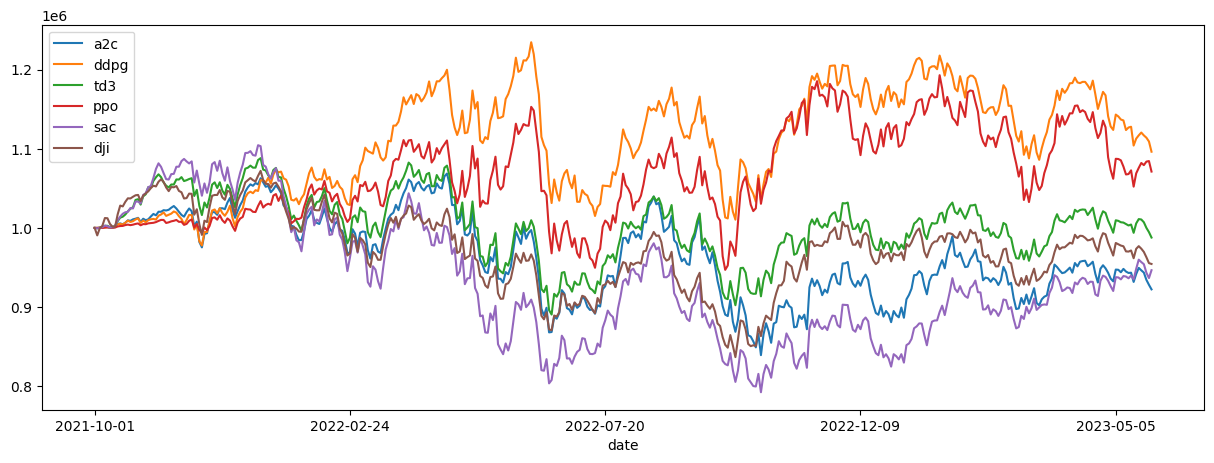

In [388]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [393]:
df_result_a2c.head()

,account_value
date,
2021-10-01,1.000000e+06
2021-10-04,9.999472e+05
2021-10-05,1.000290e+06
2021-10-06,1.000694e+06
2021-10-07,1.001235e+06


In [392]:
df_result_ppo.head()

,account_value
date,
2021-10-01,1.000000e+06
2021-10-04,9.999477e+05
2021-10-05,1.000114e+06
2021-10-06,1.000104e+06
2021-10-07,1.000388e+06


In [391]:
df_result_a2c.iloc[-1,0]

922405.4494137875

In [426]:
print('A2C로 얻은 투자 수익률>>', round((df_result_a2c.iloc[-1,0]/df_result_a2c.iloc[0,0]-1)*100,2),'%')
print('DDPG로 얻은 투자 수익률>>', round((df_result_ddpg.iloc[-1,0]/df_result_ddpg.iloc[0,0]-1)*100,2),'%')
print('TD3로 얻은 투자 수익률>>', round((df_result_td3.iloc[-1,0]/df_result_td3.iloc[0,0]-1)*100,2),'%')
print('PPO로 얻은 투자 수익률>>', round((df_result_ppo.iloc[-1,0]/df_result_ppo.iloc[0,0]-1)*100,2),'%')
print('SAC로 얻은 투자 수익률>>', round((df_result_sac.iloc[-1,0]/df_result_sac.iloc[0,0]-1)*100,2),'%')
print('DOW JONES로 얻은 투자 수익률>>', round((df_dji.iloc[-1,0]/df_dji.iloc[0,0]-1)*100,2),'%')

A2C로 얻은 투자 수익률>> -7.76 %
DDPG로 얻은 투자 수익률>> 9.62 %
TD3로 얻은 투자 수익률>> -1.21 %
PPO로 얻은 투자 수익률>> 7.12 %
SAC로 얻은 투자 수익률>> -5.34 %
DOW JONES로 얻은 투자 수익률>> -4.55 %


In [395]:
df_account_value_sac

,date,account_value
0,2021-10-01,1.000000e+06
1,2021-10-04,9.993897e+05
2,2021-10-05,1.000181e+06
3,2021-10-06,1.000914e+06
4,2021-10-07,1.002942e+06
...,...,...
410,2023-05-19,9.568650e+05
411,2023-05-22,9.541819e+05
412,2023-05-23,9.434215e+05
413,2023-05-24,9.366879e+05


In [437]:
df_actions_ppo

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2021-10-01,5,57,23,0,20,15,3,6,0
2021-10-04,5,57,23,0,20,15,3,6,0
2021-10-05,5,57,23,0,20,15,3,6,0
2021-10-06,5,57,23,0,20,15,3,6,0
2021-10-07,5,57,23,0,20,15,3,6,0
...,...,...,...,...,...,...,...,...,...
2023-05-18,0,13,3,0,0,0,0,-1,0
2023-05-19,0,13,1,0,-15,0,0,0,0
2023-05-22,0,13,3,0,0,0,0,-1,0


In [404]:
total = [0,0,0,0,0,0,0,0,0]
for index, j in enumerate(df_actions_ppo.columns):
  for i in df_actions_ppo[j]:
    if i>0 :
      total[index] += i

print(total)

[438, 9614, 2891, 3, 2088, 1384, 254, 1313, 0]


<Axes: xlabel='date'>

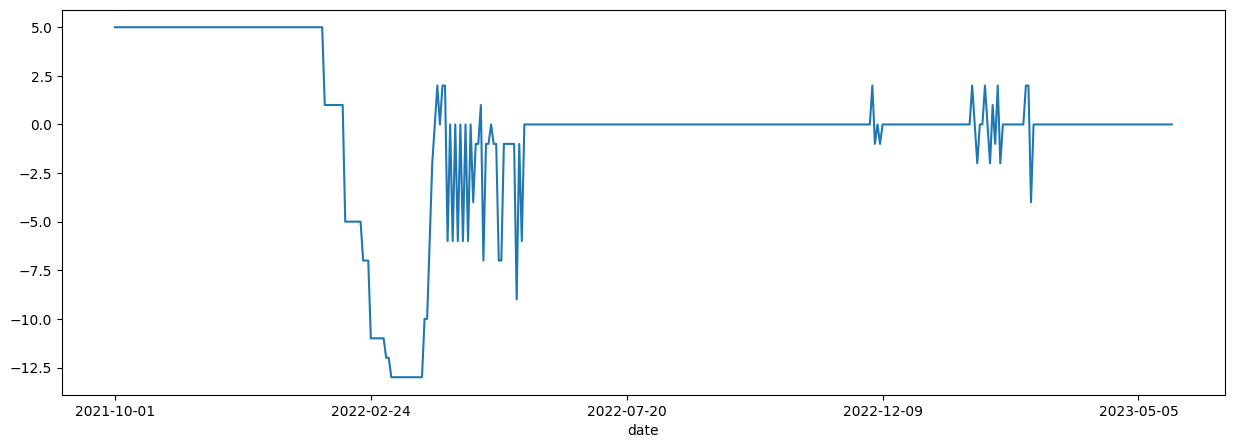

In [442]:
df_actions_ppo['XLB'].plot()

<Axes: xlabel='date'>

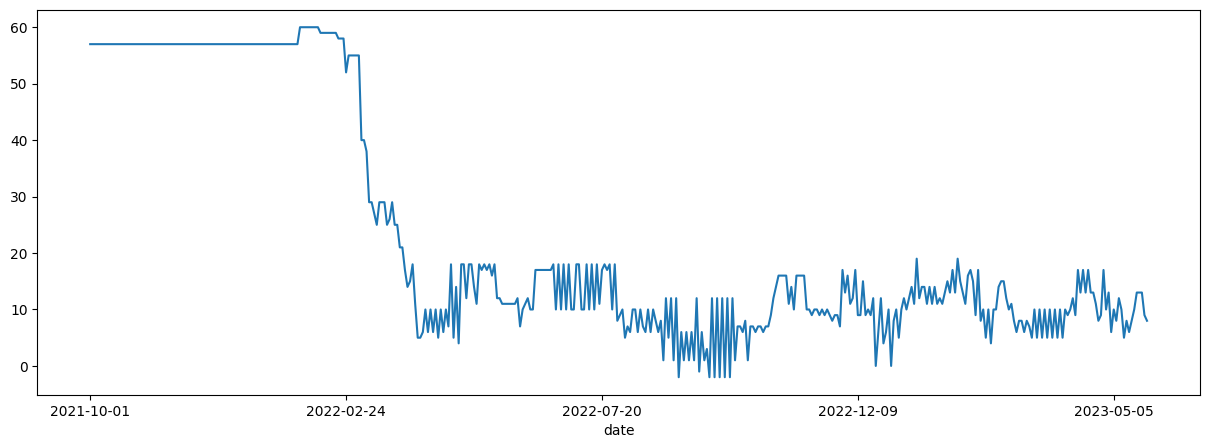

In [440]:
df_actions_ppo['XLE'].plot()

In [422]:
k = mvo_df.pivot(index='date',columns='tic',values='close').index.tolist().index('2021-10-01')
print(k)

2957


<Axes: xlabel='date'>

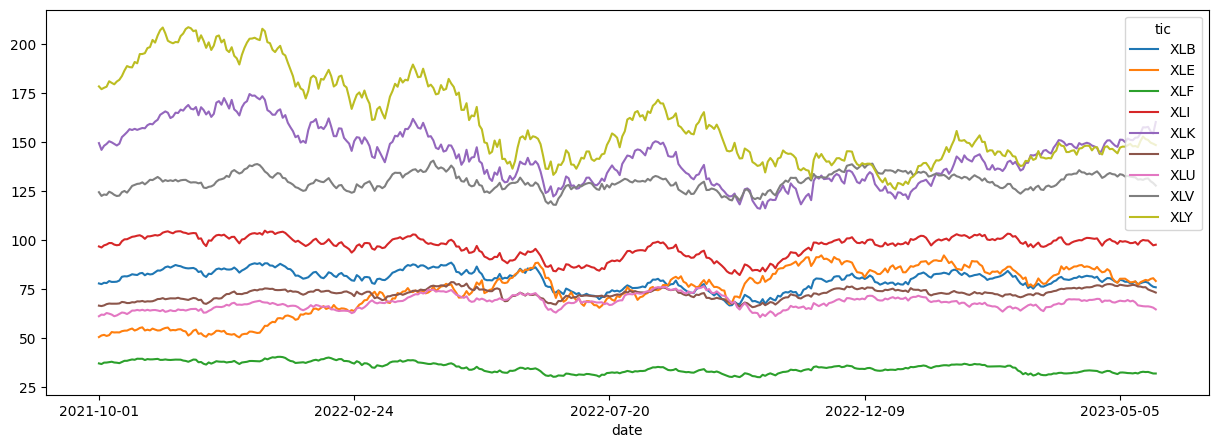

In [424]:
mvo_df.pivot(index='date',columns='tic',values='close')[k:].plot()

<Figure size 1500x500 with 0 Axes>

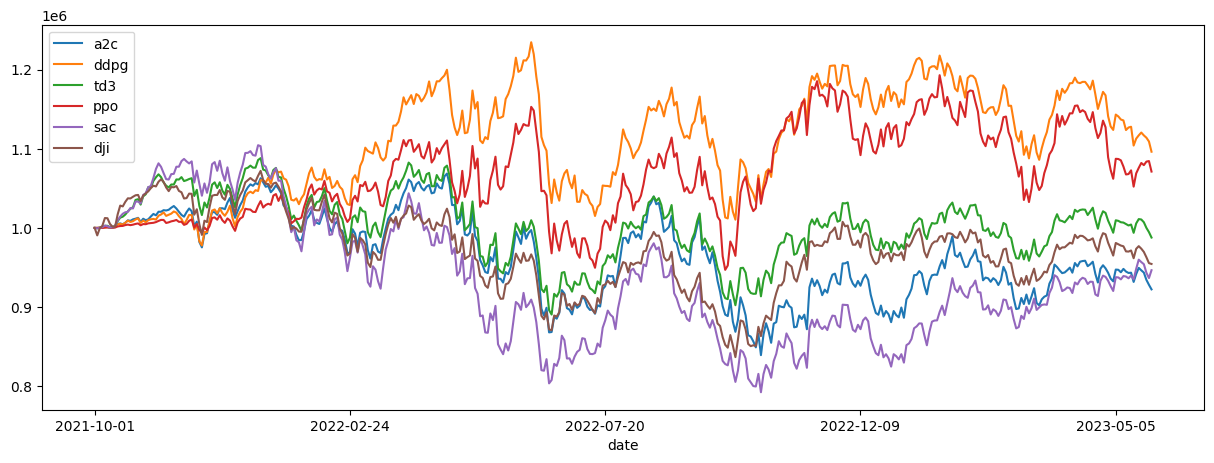

In [425]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

## Feedback